# Imports


In [1]:
import pandas as pd
from os import walk
from os.path import join

import numpy as np

import matplotlib.pyplot as plt

import nltk 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from PIL import Image
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split


%matplotlib inline

# Constants


In [2]:
EXAMPLE_FILE = 'SpamData/SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/SpamData/01_Processing/spam_assassin_corpus/spam_1' 
SPAM_2_PATH = 'SpamData/SpamData/01_Processing/spam_assassin_corpus/spam_2' 
EASY_NONSPAM_1_PATH = 'SpamData/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1' 
EASY_NONSPAM_2_PATH = 'SpamData/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2' 

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/SpamData/02_Training/test-data.txt'

THUMBS_UP_FILE = 'SpamData/SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

# Reading Files 

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
is_body = False
lines =[]

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Function

## Email body extraction

In [6]:
 def email_body_generator(path):
        for root, dirnames, filenames in walk(path):
            for file_name in filenames:
                
                filepath = join (root, file_name)
                stream = open(filepath, encoding='latin-1')
                is_body = False
                lines =[]

                for line in stream:
                    if is_body:
                        lines.append(line)
                    elif line == '\n':
                        is_body = True
                stream.close()

                email_body = '\n'.join(lines)
                
                yield file_name, email_body

In [7]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body, 'CATEGORY':classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [8]:
spam_emails_1 = df_from_directory(SPAM_1_PATH, 1)
spam_emails_2 = df_from_directory(SPAM_2_PATH, 1)
spam_emails = pd.concat([spam_emails_1, spam_emails_2])
spam_emails.head()



,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [9]:
 spam_emails.shape

(1898, 2)

In [10]:
ham_emails_1 = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails_2 = df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)
ham_emails = pd.concat([ham_emails_1, ham_emails_2])
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [11]:
ham_emails.shape

(3901, 2)

In [12]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of the entire dataframe is:', data.shape)

Shape of the entire dataframe is: (5799, 2)


In [13]:
data.tail(5)

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data cleaning: checking for missing values

In [14]:
# Check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [15]:
#Check if there are empty emails (string length = 0)
(data.MESSAGE.str.len() == 0).any()

True

In [16]:
(data.MESSAGE.str.len() == 0).sum()

3

In [17]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [18]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

## Remove system file entries from DataFrame


In [19]:
data = data.drop(['cmds'])

In [20]:
data.shape

(5796, 2)

# Add document IDs to track emails in dataset

In [21]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [22]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [23]:
 data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Save the file using pandas

In [24]:
data.to_json(DATA_JSON_FILE)

# Data Visualization

In [25]:
data.CATEGORY.value_counts()

CATEGORY
0    3900
1    1896
Name: count, dtype: int64

In [26]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

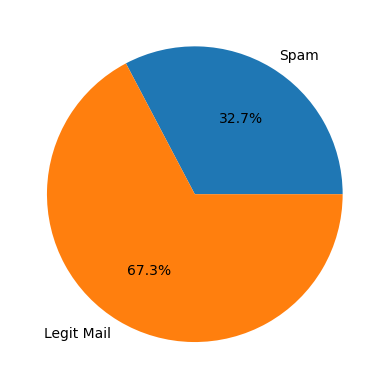

In [27]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.pie(sizes, labels=category_names, autopct = '%1.1f%%')
plt.show()

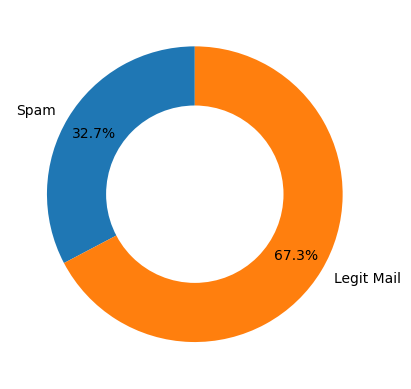

In [28]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.pie(sizes, labels=category_names, autopct = '%1.1f%%', startangle=90, pctdistance=0.8)


#draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)
plt.show()

# Natural Language Processing

## Text Pre-Processing

In [29]:
#Converting to lower case
# WE use .lower() to convert the upper into lower values.

### Downloading NLTK resources (Tokenizer & Stopwords)

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\srini\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Tokenising

In [32]:
msg = "All work and no play makes jack a dull boy"
word_tokenize(msg)

['All', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

## Removing Stopwords

In [33]:
stop_words = set(stopwords.words('english'))

In [34]:
type(stop_words)

set

 ## Word Stems and stemming

In [35]:
stemmer = PorterStemmer()

## Removing Punctuation

In [36]:
# We are going to use isalpha() method for checking for punctuation

## Removing HTML tags

In [37]:
soup = BeautifulSoup(data.at[7, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<html>
 <head>
  <title>
   ReliaQuote - Save Up To 70% On Life Insurance
  </title>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
 </head>
 <body alink="#FFCC00" leftmargin="0" link="#FFCC99" topmargin="0" vlink="#FFCC99">
  <table align="center" bgcolor="993366" border="0" cellpadding="0" cellspacing="0" height="500" width="468">
   <tr>
    <td align="left" height="43" valign="top" width="56%">
     <table border="0" cellpadding="3" cellspacing="0" width="100%">
      <tr>
       <td>
        <a href="http://theadmanager.com/server/c.asp?ad_key=YUESBHWAKMLK&amp;ext=1" target="_blank">
         <img border="0" height="32" src="http://www.reliaquote.com/banner/bannerads/images/logo6.gif" width="120"/>
        </a>
       </td>
      </tr>
     </table>
    </td>
    <td align="left" height="43" valign="top" width="44%">
    </td>
   </tr>
   <tr>
    <td align="left" height="377" valign="top" width="56%">
     <table border="0" cellpadding="0" cellspacing="0" 

In [38]:
soup.get_text()

"\n\nReliaQuote - Save Up To 70% On Life Insurance\n\n\n\n\n\n\n\n\n\n\n\n\n\xa0\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLife\n\n                                can change in an instant. That's why it is so\n\n                                important to protect your family's financial future\n\n                                with sufficient life insurance coverage.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nState\n\n                          of Residence:\n\n\n\nSelect State\nAlabama\nAlaska\nArizona\nArkansas\nCalifornia\nColorado\nConnecticut\nDelaware\nDist. of Columbia\nFlorida\nGeorgia\nHawaii\nIdaho\nIllinois\nIndiana\nIowa\nKansas\nKentucky\nLouisiana\nMaine\nMaryland\nMassachusetts\nMichigan\nMinnesota\nMississippi\nMissouri\nMontana\nNebraska\nNevada\nNew Hampshire\nNew Jersey\nNew Mexico\nNew York\nNorth Carolina\nNorth Dakota\nOhio\nOklahoma\nOregon\nPennsylvania\nRhode Island\nSouth Carolina\nSouth Dakota\nTennessee\nTexas\nUtah\nVermont\nVirginia\nWashington\nWest V

# Functions for Email Processing


In [39]:
def clean_message(message, stemmer=PorterStemmer(),
                 stop_words = set(stopwords.words('english'))):
    
    #Removing HTML tags as well
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    #Splits up the words and converts into lower
    words = word_tokenize(cleaned_text.lower())
        
    filtered_words = []
    
    for word in words:
        #Remove the stop words and punctuation 
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [40]:
clean_message(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

# Using Apply function


In [41]:
%%time

#use apply() on  all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_message)

C:\Users\srini\AppData\Local\Temp\ipykernel_1944\300008663.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\srini\AppData\Local\Temp\ipykernel_1944\300008663.py:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


CPU times: total: 40.1 s
Wall time: 40.5 s


In [42]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

 ## Using logic to slice DataFrames

In [43]:
#Storing indices of the spam and ham messages
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [44]:
doc_ids_ham

Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       ...
       5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
      dtype='int64', name='DOC_ID', length=3900)

### Subsetting a series using index

In [45]:
# We are creating subsets of the messages that are spam an ham
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_spam = nested_list.loc[doc_ids_spam]

In [46]:
nested_list_ham.shape

(3900,)

In [47]:
nested_list_ham.head()

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
Name: MESSAGE, dtype: object

In [48]:
nested_list_spam.tail()

DOC_ID
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, dtype: object

In [49]:
nested_list_ham.shape

(3900,)

In [50]:
#Finding out total number of unique words in the ham messages
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0]

20815

In [51]:
#Finding out total number of unique words in the spam messages
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape[0]

13242

# Wordcloud for our Ham and Spam Messages

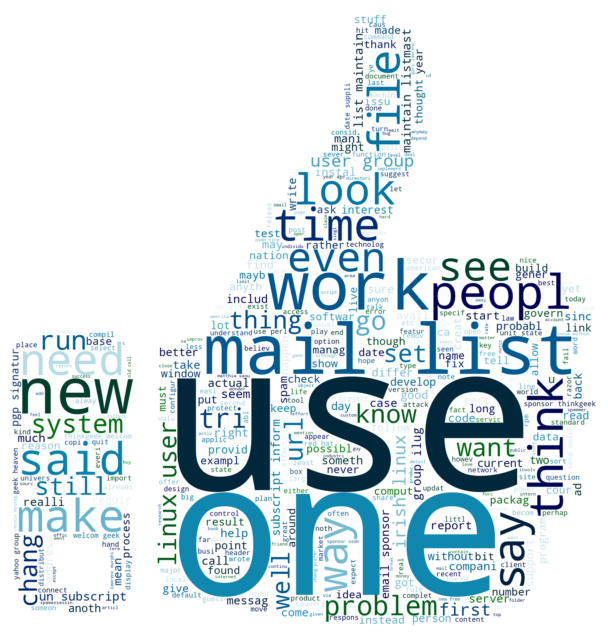

In [52]:
#Wordcloud for ham messages and the words use are stemmed.

icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

ham_str = ' '.join(flat_list_ham) #Generate the text as a string for the word cloud

rgb_array = np.array(image_mask) # Converts the image object to an array


word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=400, colormap='ocean')

word_cloud.generate(ham_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

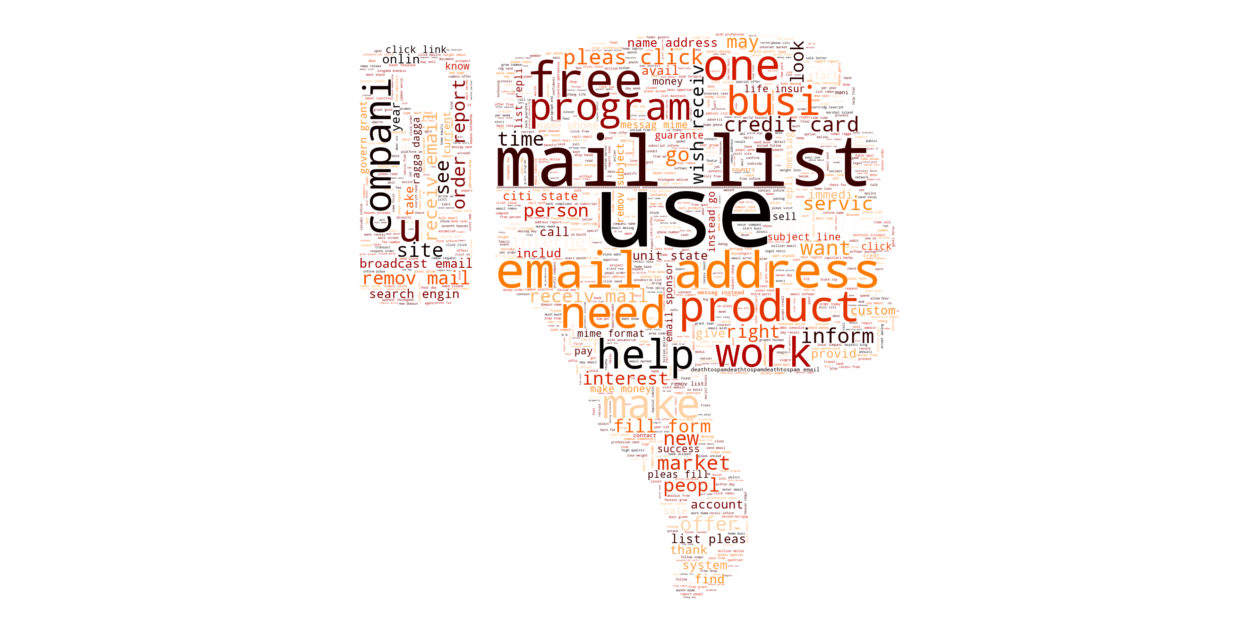

In [53]:
#Wordcloud for spam messages and the words use are stemmed.

icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

spam_str = ' '.join(flat_list_spam) #Generate the text as a string for the word cloud

rgb_array = np.array(image_mask) # Converts the image object to an array


word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=1000, colormap='gist_heat')

word_cloud.generate(spam_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocab and Dictionary

In [54]:
stemmed_nested_list = data.MESSAGE.apply(clean_message)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\srini\AppData\Local\Temp\ipykernel_1944\300008663.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\srini\AppData\Local\Temp\ipykernel_1944\300008663.py:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [55]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('No of Unique words',unique_words.shape[0])
unique_words.head()

No of Unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
Name: count, dtype: int64

In [56]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[0:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
Name: count, dtype: int64


In [57]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD':frequent_words.index.values}, index = word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the vocab to a csv file


In [58]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Generate features and a sparse matrix

### Creating a DataFrame with one Word per column

In [59]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [60]:
word_columns_df.shape


(5796, 7671)

### Splitting the date into training and testing dataset

In [61]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, 
                                                   test_size=0.3, random_state=42)

In [62]:
print('No of training samples:', X_train.shape[0])
print('Fraction  of training set:', X_train.shape[0] / word_columns_df.shape[0])

No of training samples: 4057
Fraction  of training set: 0.6999654934437544


In [63]:
X_train.index.name =X_test.index.name= 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


 ### Creating a Sparse Matrix for the Training Data

In [64]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index)

pandas.core.indexes.base.Index

In [65]:
def make_sparse_matrix(df, indexed_words, labels):
    no_rows = df.shape[0]
    no_cols = df.shape[1]
    
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(no_rows):
        for j in range(no_cols):
            
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 
                       'DOC_ID': doc_id,
                       'OCCURRENCE': 1,
                       'WORD_ID':word_id}
                dict_list.append(item)
            
    return pd.DataFrame(dict_list)
    
    

In [66]:
%%time

sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: total: 11min 30s
Wall time: 11min 58s


## Combine occurances with the pandas groupby() Method

In [67]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [68]:
print(type(train_grouped))


<class 'pandas.core.frame.DataFrame'>


In [69]:
vocab.at[2, 'VOCAB_WORD']

'list'

In [70]:
data.MESSAGE[2]

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [71]:
train_grouped.head

<bound method NDFrame.head of         DOC_ID  WORD_ID  LABEL  OCCURRENCE
0            0        2      1           1
1            0        3      1           2
2            0        4      1           1
3            0        7      1           3
4            0       11      1           1
...        ...      ...    ...         ...
258355    5795     2035      0           2
258356    5795     2040      0           1
258357    5795     2272      0           1
258358    5795     2342      0           1
258359    5795     2370      0           1

[258360 rows x 4 columns]>

In [72]:
train_grouped.shape

(258360, 4)

### Save training data as .txt file

In [73]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [74]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURRENCE'], dtype='object')

In [75]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [76]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [77]:
X_test.tail()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
5295,thu,jul,joseph,barrera,iii,wrote,chri,arkenberg,wrote,cheer,...,None,None,None,None,None,None,None,None,None,None
5740,securityfocu,linux,newslett,newslett,sponsor,securityfocu,deepsight,threat,manag,system,...,None,None,None,None,None,None,None,None,None,None
5069,thu,jul,matthia,saou,wrote,upon,time,matthia,wrote,see,...,None,None,None,None,None,None,None,None,None,None
1293,tremend,save,toner,inkjet,fax,thermal,replenish,toner,go,secret,...,None,None,None,None,None,None,None,None,None,None
4354,forteana,jayn,ayri,wrote,think,letter,oh,right,give,go,...,None,None,None,None,None,None,None,None,None,None


In [78]:
y_test.tail()

DOC_ID
5295    0
5740    0
5069    0
1293    1
4354    0
Name: CATEGORY, dtype: int64

In [79]:
%%time

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: total: 5min 8s
Wall time: 5min 15s


In [80]:
sparse_test_df.shape

(203366, 4)

In [81]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()

In [83]:
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [84]:
test_grouped.shape

(117776, 4)

In [85]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')